In [1]:
import glob
import os
import pandas as pd
import numpy as np
import math
from collections import Counter
from scipy.sparse import csr_matrix, vstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from tqdm import tqdm

In [2]:

# Path to the DGA_Botnets_Domains folder
dga_domains_path = 'DGA_Botnets_Domains/*.txt'  # Update the path as needed
legit_domains_file = 'DGA_Botnets_Domains/legit-1000000.txt'  # Update this path

# Load DGA domains from all TXT files in the folder, excluding the legit file
dga_domains = []
dga_files = glob.glob(dga_domains_path)

for file in dga_files:
    # Check if the file is not the legitimate domains file
    if 'legit-1000000.txt' not in file:  # Exclude the legit domains file
        with open(file, 'r') as f:
            domains = [line.strip() for line in f.readlines() if line.strip()]  # Remove any empty lines
            dga_domains.extend(domains)

# Load legitimate domains from the legit file
with open(legit_domains_file, 'r') as f:
    legit_domains = [line.strip() for line in f.readlines() if line.strip()]  # Remove any empty lines

# Create DataFrame with labels
data = pd.DataFrame({
    'domain': dga_domains + legit_domains,
    'label': [1] * len(dga_domains) + [0] * len(legit_domains)  # 1 for DGA, 0 for Legit
})

# Display the first few rows
print(data.head())
print(f'Total domains loaded: {len(data)}')


                                   domain  label
0    86284a03e06c927540df37e24768fde2.org      1
1  e347558de8c7d3a0642ba5642a0c1870.cz.cc      1
2   18b0923326d19d0edb8f41de1ef6c947.info      1
3  b17a2dbfe20ff39b536b5df798c2d020.cz.cc      1
4   216a4dae8733e717e2bf8d458ee1426f.info      1
Total domains loaded: 4300000


In [3]:


# Function to extract n-grams from a domain
def extract_ngrams(domain, ngram_range=(2, 5)):
    ngrams = []
    min_n, max_n = ngram_range
    for n in range(min_n, max_n + 1):
        ngrams.extend([domain[i:i+n] for i in range(len(domain) - n + 1)])
    return ngrams

# Function to calculate Term Frequency (TF)
def calculate_tf(ngrams):
    tf = Counter(ngrams)
    max_freq = max(tf.values()) if tf else 1
    for ngram in tf:
        tf[ngram] /= max_freq
    return tf

# Create an SQLite database to store n-gram counts
conn = sqlite3.connect('ngram_counts.db')
cursor = conn.cursor()

# Create a table to store n-gram counts
cursor.execute('''
    CREATE TABLE IF NOT EXISTS ngram_counts (
        ngram TEXT PRIMARY KEY,
        count INTEGER
    )
''')
conn.commit()

# Chunk size for processing
chunk_size = 5000
total_docs = len(data)

# Process the dataset in chunks and update n-gram counts in the SQLite database
for start_idx in tqdm(range(0, total_docs, chunk_size), desc="Processing Data"):
    chunk = data['domain'][start_idx:start_idx + chunk_size]
    ngram_counter = Counter()
    for domain in chunk:
        ngrams = extract_ngrams(domain)
        ngram_counter.update(set(ngrams))  # Use set to avoid duplicates within the same domain

    # Update counts in the database
    for ngram, count in ngram_counter.items():
        cursor.execute('''
            INSERT INTO ngram_counts (ngram, count)
            VALUES (?, ?)
            ON CONFLICT(ngram) DO UPDATE SET count = count + ?
        ''', (ngram, count, count))

    conn.commit()

    # Read n-gram counts from the database and calculate IDF
idf = {}
cursor.execute('SELECT COUNT(*) FROM ngram_counts')
total_ngrams = cursor.fetchone()[0]

# Calculate IDF for each n-gram
cursor.execute('SELECT ngram, count FROM ngram_counts')
for ngram, count in tqdm(cursor.fetchall(), desc="Calculating IDF"):
    idf[ngram] = math.log(total_docs / (count + 1))

# Create n-gram to index mapping
ngram_index = {ngram: idx for idx, ngram in enumerate(sorted(idf.keys()))}

# Close the SQLite connection
conn.close()

# Build the sparse TF-IDF matrix in chunks
def compute_tfidf_chunks(data_chunk, idf, ngram_index):
    rows = []
    cols = []
    values = []
    for row_idx, domain in enumerate(data_chunk):
        ngrams = extract_ngrams(domain)
        tf = calculate_tf(ngrams)
        tfidf = {term: tf[term] * idf.get(term, 0) for term in tf}
        for term, value in tfidf.items():
            if term in ngram_index:
                col_idx = ngram_index[term]
                rows.append(row_idx)
                cols.append(col_idx)
                values.append(value)
    return csr_matrix((values, (rows, cols)), shape=(len(data_chunk), len(ngram_index)))

# Build the sparse TF-IDF matrix
sparse_chunks = []
for start_idx in tqdm(range(0, total_docs, chunk_size), desc="Building Sparse Matrix"):
    chunk = data['domain'][start_idx:start_idx + chunk_size]
    sparse_chunk = compute_tfidf_chunks(chunk, idf, ngram_index)
    sparse_chunks.append(sparse_chunk)

# Combine all sparse chunks into a single sparse matrix
tfidf_sparse_matrix = vstack(sparse_chunks)

# Add labels as a separate column
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['label'])

print(f"Sparse matrix shape: {tfidf_sparse_matrix.shape}")
print(f"Labels shape: {labels.shape}")




Building Sparse Matrix: 100%|██████████| 860/860 [09:54<00:00,  1.45it/s]


Sparse matrix shape: (4300000, 16061427)
Labels shape: (4300000,)


In [4]:

# Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(tfidf_sparse_matrix, labels, test_size=0.2, random_state=42)

# Initialize Logistic Regression Model with the provided parameters
logreg_model = LogisticRegression(
    penalty='l2',              # Regularization term, L2 regularization (default)
    dual=False,                # Use the dual formulation for optimization (set to False for more efficiency when n_samples > n_features)
    tol=0.0001,                # Tolerance for stopping criteria
    C=1.0,                     # Inverse of regularization strength (default is 1.0)
    fit_intercept=True,        # Whether to include an intercept in the model (default is True)
    intercept_scaling=1,       # Scaling of the intercept term
    class_weight=None,         # Weights associated with classes (None means uniform weights)
    random_state=42,           # Seed for random number generation (ensures reproducibility)
    solver='lbfgs',            # Solver for optimization (default 'lbfgs', suitable for smaller datasets)
    max_iter=1000,             # Maximum number of iterations for convergence
    multi_class='auto',        # Multi-class handling (auto handles binary and multiclass automatically)
    verbose=0,                 # Verbosity level (0 for no output)
    warm_start=False,          # Whether to reuse the previous solution (False means fresh start)
    n_jobs=None,               # Number of CPU cores to use for computation (None means 1 core)
    l1_ratio=None              # Only used for elastic net (if penalty='elasticnet'), None means L2 penalty
)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg_model.predict(X_test)

# Print classification report to evaluate performance
print(classification_report(y_test, y_pred))

# Save the model using joblib for future use
joblib.dump(logreg_model, 'logreg_model.pkl')

print("Model trained and saved as 'logreg_model.pkl'.")


C:\Users\Tushar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.95      0.95      0.95    199869
           1       0.98      0.98      0.98    660131

    accuracy                           0.98    860000
   macro avg       0.97      0.97      0.97    860000
weighted avg       0.98      0.98      0.98    860000

Model trained and saved as 'logreg_model.pkl'.


In [5]:
# Load the trained Logistic Regression model
logreg_model = joblib.load('logreg_model.pkl')
print("Model loaded successfully.")


Model loaded successfully.


In [10]:
def classify_domain(domain_name, model, idf, ngram_index):
    # Step 1: Extract n-grams from the domain
    ngrams = extract_ngrams(domain_name)
    
    # Step 2: Calculate the TF (Term Frequency) for the n-grams
    tf = calculate_tf(ngrams)
    
    # Step 3: Calculate the TF-IDF for each n-gram using the pre-calculated IDF
    tfidf = {term: tf[term] * idf.get(term, 0) for term in tf}
    
    # Step 4: Create a sparse vector for the domain's TF-IDF features
    rows = []
    cols = []
    values = []
    for term, value in tfidf.items():
        if term in ngram_index:
            col_idx = ngram_index[term]
            rows.append(0)  # Only one row (since we're classifying one domain at a time)
            cols.append(col_idx)
            values.append(value)
    
    # Step 5: Create a sparse matrix (1 row, many columns)
    tfidf_sparse_vector = csr_matrix((values, (rows, cols)), shape=(1, len(ngram_index)))
    
    # Step 6: Predict using the Logistic Regression model
    prediction = model.predict(tfidf_sparse_vector)
    
    # Return the prediction result (1 = DGA, 0 = Legit)
    return "DGA" if prediction[0] == 1 else "Legit"

# Example usage:
new_domain = "shoppingsaleonline.com"
prediction = classify_domain(new_domain, logreg_model, idf, ngram_index)
print(f"The domain '{new_domain}' is classified as: {prediction}")


The domain 'shoppingsaleonline.com' is classified as: Legit



Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    199869
           1       0.98      0.98      0.98    660131

    accuracy                           0.98    860000
   macro avg       0.97      0.97      0.97    860000
weighted avg       0.98      0.98      0.98    860000



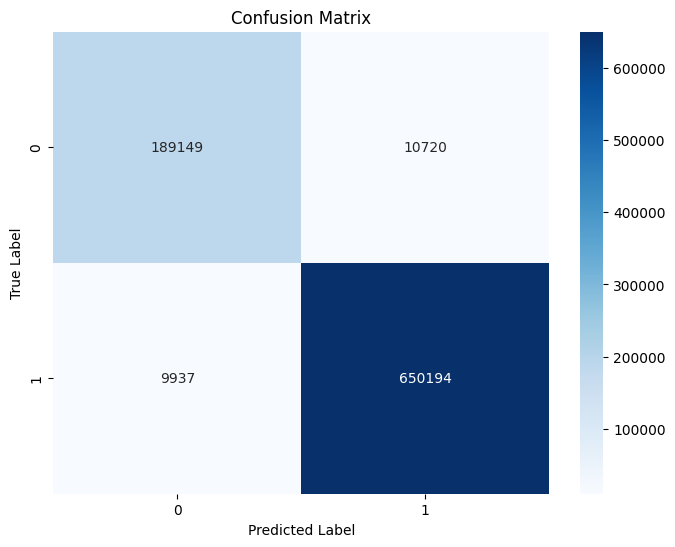

In [12]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [11]:
# List of DGA domains to test
dga_test_domains = [
    "happybirthdaycat.com",
    "quickbrownfoxjumpsover.net",
    "thelazydogsleeps.org",
    "xytqzoen.org",
    "lqmgbczx.net",
    "abdkglpfv.co",
    "vgfurhex.de",
    "owciwroj.info",
    "gsartexp.in",
    "ptgkzwvu.cc",
    "zyfucmojq.ru",
    "nvpkunqlz.com",
    "ylrjhbtds.com",
    "qwiorlhps.info",
    "cvusndju.org"
]

# Classify each domain
for domain in dga_test_domains:
    prediction = classify_domain(domain, logreg_model, idf, ngram_index)
    print(f"The domain '{domain}' is classified as: {prediction}")


The domain 'happybirthdaycat.com' is classified as: Legit
The domain 'quickbrownfoxjumpsover.net' is classified as: DGA
The domain 'thelazydogsleeps.org' is classified as: Legit
The domain 'xytqzoen.org' is classified as: DGA
The domain 'lqmgbczx.net' is classified as: DGA
The domain 'abdkglpfv.co' is classified as: DGA
The domain 'vgfurhex.de' is classified as: DGA
The domain 'owciwroj.info' is classified as: DGA
The domain 'gsartexp.in' is classified as: DGA
The domain 'ptgkzwvu.cc' is classified as: DGA
The domain 'zyfucmojq.ru' is classified as: DGA
The domain 'nvpkunqlz.com' is classified as: DGA
The domain 'ylrjhbtds.com' is classified as: DGA
The domain 'qwiorlhps.info' is classified as: DGA
The domain 'cvusndju.org' is classified as: DGA


In [9]:
import joblib

# Save the trained model
joblib.dump(logreg_model, 'logreg_model.pkl')

# Save other important components
joblib.dump(idf, 'idf.pkl')              # Save IDF dictionary
joblib.dump(ngram_index, 'ngram_index.pkl')  # Save n-gram index mapping

print("Model and supporting files saved successfully.")


Model and supporting files saved successfully.
